# Creating a PINN to simulation 2D incompressible Navier-Stokes

We will taken training data from OpenFOAM tutorial.

In [34]:
import numpy as np
import matplotlib.pyplot as plt
import Ofpp as ofpp
import matplotlib.animation as animation
import os
import torch
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import math

In [35]:
#Data wrangling to get 1D tensors for X,Y,t,u,v,p for interior and boundary conditions
#Convert to correct format
#Scaling
#Train-test split
#QC of train-test split
#Define NN structure
#Train network
#QC prediction

In [36]:
#Read in key parameters from control dict eventually
openfoam_case_path = "../../data/cavity-re100/"

start_time = 0
end_time = 5
dt = 0.005
ofoam_write_interval = 1
ofoam_output_inc = dt * ofoam_write_interval
ofoam_num_outputs = ( end_time / ofoam_output_inc ) + 1
numt = len(np.arange(start_time,end_time + ofoam_output_inc,ofoam_output_inc))

x_start = 0
x_end = 1
numx = 20

y_start = 0
y_end = 2
numy = 20

shape = (numt,numy,numx)
print(f"OpenFOAM data shape: {shape}")

print(f"Start: {start_time} end: {end_time}")
print(f"dt: {dt} num timesteps: {numt}")
print(f"Write interval: {ofoam_write_interval} ofoam_num_outputs: {ofoam_num_outputs}")

grid2d_x, grid2d_y = np.meshgrid(
    np.linspace(x_start,x_end,numx),
    np.linspace(y_start,y_end,numy))

u_full = np.zeros(shape)
v_full = np.zeros(shape)
p_full = np.zeros(shape)

openfoam_outputs = os.listdir(openfoam_case_path)
openfoam_outputs.remove("constant")
openfoam_outputs.remove("system")
openfoam_outputs.remove("0_orig")
openfoam_outputs.sort()
openfoam_outputs = openfoam_outputs[::ofoam_write_interval]

idx = 0
for time in openfoam_outputs:
    openfoam_timestep = openfoam_case_path + time
    if time == "0":
        u_full[idx,:,:] = 0
        u_full[idx,-1,:] = 1 #Initial condition, last row all columns
        
        v_full[idx,:,:] = 0
        
        p_full[idx,:,:] = 0
    else:
        U = ofpp.parse_internal_field(f"{openfoam_timestep}/U")
        u_full[idx,:,:] = U[:,0].reshape((numy,numx))
        v_full[idx,:,:] = U[:,1].reshape((numy,numx))
        
        p_full[idx,:,:] = ofpp.parse_internal_field(f"{openfoam_timestep}/p").reshape((numy,numx))
    
    idx += 1


OpenFOAM data shape: (1001, 20, 20)
Start: 0 end: 5
dt: 0.005 num timesteps: 1001
Write interval: 1 ofoam_num_outputs: 1001.0


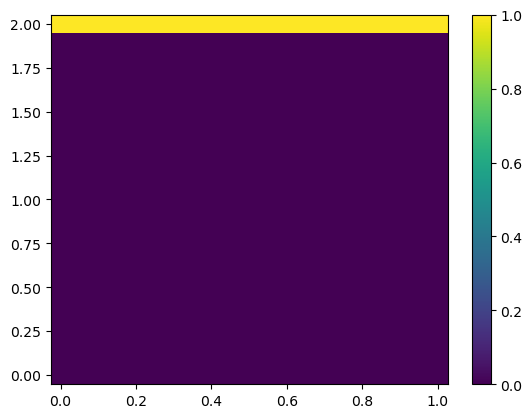

In [37]:
fig, ax = plt.subplots()
fig.colorbar(ax.pcolormesh(grid2d_x, grid2d_y, u_full[0,:,:], shading='gouraud'), orientation='vertical')
ax.pcolormesh(grid2d_x, grid2d_y,u_full[0,:,:])
plt.show()

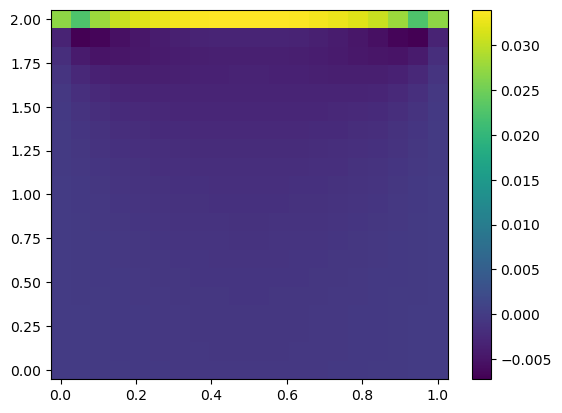

In [38]:
fig, ax = plt.subplots()
fig.colorbar(ax.pcolormesh(grid2d_x, grid2d_y, u_full[1,:,:], shading='gouraud'), orientation='vertical')
ax.pcolormesh(grid2d_x, grid2d_y,u_full[1,:,:])
plt.show()

In [39]:
#Use GPU if available
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cpu'

In [40]:
y, t, x = np.meshgrid(
    np.linspace(y_start,y_end,numy),
    np.linspace(start_time,end_time,numt), #z direction
    np.linspace(x_start,x_end,numx)) #cols

print(x.shape)

#Return an array in form t, x, y
features = np.concatenate((t.flatten().reshape(-1,1),y.flatten().reshape(-1,1),x.flatten().reshape(-1,1)), axis=1)
print(features.shape)

(1001, 20, 20)
(400400, 3)


In [41]:
print(x[0,0,:])

print(y[0,:,0])

print(t[:,0,0])

[0.         0.05263158 0.10526316 0.15789474 0.21052632 0.26315789
 0.31578947 0.36842105 0.42105263 0.47368421 0.52631579 0.57894737
 0.63157895 0.68421053 0.73684211 0.78947368 0.84210526 0.89473684
 0.94736842 1.        ]
[0.         0.10526316 0.21052632 0.31578947 0.42105263 0.52631579
 0.63157895 0.73684211 0.84210526 0.94736842 1.05263158 1.15789474
 1.26315789 1.36842105 1.47368421 1.57894737 1.68421053 1.78947368
 1.89473684 2.        ]
[0.    0.005 0.01  ... 4.99  4.995 5.   ]


In [42]:
#Order is T,Y,X
print(features[1,:])
print(features[4000,:])
print(features[20,:])

[0.         0.         0.05263158]
[0.05 0.   0.  ]
[0.         0.10526316 0.        ]


In [43]:
std_scaler = StandardScaler()
scaler_features = std_scaler.fit(features)

OK, so we have our features x,y and t locations.

In the order T,Y,X

Now we need to extract our labels ensuring that the arrays are reshaped the same way as the features arrays.

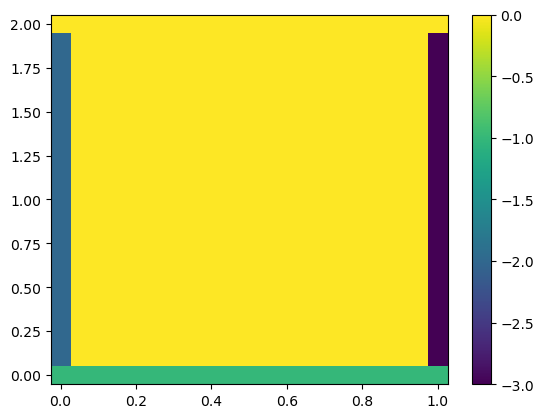

In [44]:
#Lets check our numpy slicing syntax is correct by labelling the boundary locations on a plot
tmp_u = np.zeros(u_full[1,:,:].shape)
tmp_u[0,:] = -1 #bottom wall
tmp_u[1:-1,0] = -2 #left wall
tmp_u[1:-1,-1] = -3 #right wall

fig, ax = plt.subplots()
fig.colorbar(ax.pcolormesh(grid2d_x, grid2d_y, tmp_u, shading='gouraud'), orientation='vertical')
ax.pcolormesh(grid2d_x, grid2d_y, tmp_u)
plt.show()


In [45]:
u_basewall  = u_full[:,0,:]
u_leftwall  = u_full[:,1:-1,0]
u_rightwall = u_full[:,1:-1,-1]

u_basewall_labels = u_basewall.flatten().reshape(-1,1)
u_leftwall_labels = u_leftwall.flatten().reshape(-1,1)
u_rightwall_labels = u_rightwall.flatten().reshape(-1,1)

v_basewall  = v_full[:,0,:]
v_leftwall  = v_full[:,1:-1,0]
v_rightwall = v_full[:,1:-1,-1]

v_basewall_labels = v_basewall.flatten().reshape(-1,1)
v_leftwall_labels = v_leftwall.flatten().reshape(-1,1)
v_rightwall_labels = v_rightwall.flatten().reshape(-1,1)

p_basewall  = p_full[:,0,:]
p_leftwall  = p_full[:,1:-1,0]
p_rightwall = p_full[:,1:-1,-1]

p_basewall_labels = p_basewall.flatten().reshape(-1,1)
p_leftwall_labels = p_leftwall.flatten().reshape(-1,1)
p_rightwall_labels = p_rightwall.flatten().reshape(-1,1)

print(u_basewall.shape)
print(u_leftwall.shape)
print(u_rightwall.shape)

print(u_basewall_labels.shape)
print(u_leftwall_labels.shape)
print(u_rightwall_labels.shape)

(1001, 20)
(1001, 18)
(1001, 18)
(20020, 1)
(18018, 1)
(18018, 1)


In [46]:
basewall_features_x = x[:,0,:]
basewall_features_y = y[:,0,:]
basewall_features_t = t[:,0,:]

leftwall_features_x = x[:,1:-1,0]
leftwall_features_y = y[:,1:-1,0]
leftwall_features_t = t[:,1:-1,0]

rightwall_features_x = x[:,1:-1,-1]
rightwall_features_y = y[:,1:-1,-1]
rightwall_features_t = t[:,1:-1,-1]

features_basewall = np.concatenate(
    (
        basewall_features_t.flatten().reshape(-1,1),
        basewall_features_y.flatten().reshape(-1,1),
        basewall_features_x.flatten().reshape(-1,1)
    ), 
    axis=1)

features_leftwall = np.concatenate(
    (
        leftwall_features_t.flatten().reshape(-1,1),
        leftwall_features_y.flatten().reshape(-1,1),
        leftwall_features_x.flatten().reshape(-1,1)
    ), 
    axis=1)

features_rightwall = np.concatenate(
    (
        rightwall_features_t.flatten().reshape(-1,1),
        rightwall_features_y.flatten().reshape(-1,1),
        rightwall_features_x.flatten().reshape(-1,1)
    ), 
    axis=1)

print(features_basewall.shape)
print(features_rightwall.shape)
print(features_leftwall.shape)

print("Starting index for each boundary (t,y,x)")
print(features_basewall[0,...])
print(features_rightwall[0,...])
print(features_leftwall[0,...])

print("Final index for each boundary (t,y,x)")
print(features_basewall[-1,...])
print(features_rightwall[-1,...])
print(features_leftwall[-1,...])


(20020, 3)
(18018, 3)
(18018, 3)
Starting index for each boundary (t,y,x)
[0. 0. 0.]
[0.         0.10526316 1.        ]
[0.         0.10526316 0.        ]
Final index for each boundary (t,y,x)
[5. 0. 1.]
[5.         1.89473684 1.        ]
[5.         1.89473684 0.        ]


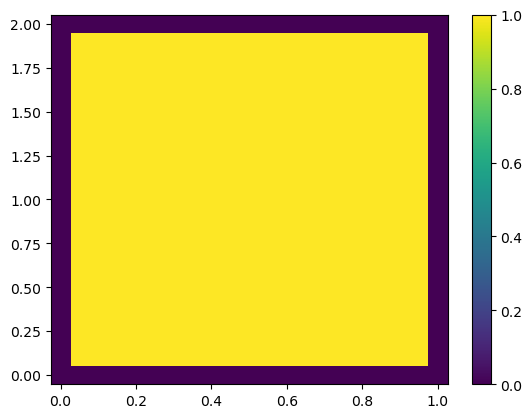

In [47]:
#Now lets get the interior datapoints
#Again lets start with a visual check of the syntax
tmp_u = np.zeros(u_full[0,:,:].shape)
tmp_u[1:-1,1:-1] = 1 #all rows and columns but first and last

#Interior should be 1, boundaries should be zero

fig, ax = plt.subplots()
fig.colorbar(ax.pcolormesh(grid2d_x, grid2d_y, tmp_u, shading='gouraud'), orientation='vertical')
ax.pcolormesh(grid2d_x, grid2d_y, tmp_u)
plt.show()

Great that looks good, lets pull out the interior labels and features from their respective arrays.

In [48]:
interior_features_x = x[:,1:-1,1:-1]
interior_features_y = y[:,1:-1,1:-1]
interior_features_t = t[:,1:-1,1:-1]

In [49]:
features_interior = np.concatenate(
    (
        interior_features_t.flatten().reshape(-1,1),
        interior_features_y.flatten().reshape(-1,1),
        interior_features_x.flatten().reshape(-1,1)
    ), 
    axis=1)

print(features_interior.shape)

print("Starting index for interior points (t,y,x)")
print(features_interior[0,...])

print("Final index for interior (t,y,x)")
print(features_interior[-1,...])


(324324, 3)
Starting index for interior points (t,y,x)
[0.         0.10526316 0.05263158]
Final index for interior (t,y,x)
[5.         1.89473684 0.94736842]


In [50]:
#Now need interior labels
u_interior  = u_full[:,1:-1,1:-1]
u_interior_labels = u_interior.flatten().reshape(-1,1)

v_interior  = v_full[:,1:-1,1:-1]
v_interior_labels = v_interior.flatten().reshape(-1,1)

p_interior  = p_full[:,1:-1,1:-1]
p_interior_labels = p_interior.flatten().reshape(-1,1)

Great that also looks good

So we now have data for the loss condition:

- boundary condition points (should all equal 0)
- interior points (should honour the PDE)

The next steps are to scale our features

In [51]:
#Scale features
scaled_features_basewall = scaler_features.transform(features_basewall)
scaled_features_interior = scaler_features.transform(features_interior)
scaled_features_leftwall = scaler_features.transform(features_leftwall)
scaled_features_rightwall = scaler_features.transform(features_rightwall)

scaled_features_basewall = features_basewall
scaled_features_interior = features_interior
scaled_features_leftwall = features_leftwall
scaled_features_rightwall = features_rightwall

In [52]:
#Now split each dataset into training and testing

#Train test splitting
test_size = 0.95

#Interior
(
    x_interior_train,
    x_interior_test,
    y_interior_train,
    y_interior_test,
    t_interior_train,
    t_interior_test,
    u_interior_labels_train,
    u_interior_labels_test,
    v_interior_labels_train,
    v_interior_labels_test,
    p_interior_labels_train,
    p_interior_labels_test,
) = train_test_split(
    scaled_features_interior[:,2], 
    scaled_features_interior[:,1], 
    scaled_features_interior[:,0],
    u_interior_labels,
    v_interior_labels,
    p_interior_labels,
    test_size=test_size)

#Basewall
(
    x_basewall_train,
    x_basewall_test,
    y_basewall_train,
    y_basewall_test,
    t_basewall_train,
    t_basewall_test,
    u_basewall_labels_train,
    u_basewall_labels_test,
    v_basewall_labels_train,
    v_basewall_labels_test,
    p_basewall_labels_train,
    p_basewall_labels_test,
) = train_test_split(
    scaled_features_basewall[:,2], 
    scaled_features_basewall[:,1], 
    scaled_features_basewall[:,0],
    u_basewall_labels,
    v_basewall_labels,
    p_basewall_labels,
    test_size=test_size)

#Leftwall
(
    x_leftwall_train,
    x_leftwall_test,
    y_leftwall_train,
    y_leftwall_test,
    t_leftwall_train,
    t_leftwall_test,
    u_leftwall_labels_train,
    u_leftwall_labels_test,
    v_leftwall_labels_train,
    v_leftwall_labels_test,
    p_leftwall_labels_train,
    p_leftwall_labels_test,
) = train_test_split(
    scaled_features_leftwall[:,2], 
    scaled_features_leftwall[:,1], 
    scaled_features_leftwall[:,0],
    u_leftwall_labels,
    v_leftwall_labels,
    p_leftwall_labels,
    test_size=test_size)

#Rightwall
(
    x_rightwall_train,
    x_rightwall_test,
    y_rightwall_train,
    y_rightwall_test,
    t_rightwall_train,
    t_rightwall_test,
    u_rightwall_labels_train,
    u_rightwall_labels_test,
    v_rightwall_labels_train,
    v_rightwall_labels_test,
    p_rightwall_labels_train,
    p_rightwall_labels_test,
) = train_test_split(
    scaled_features_rightwall[:,2], 
    scaled_features_rightwall[:,1], 
    scaled_features_rightwall[:,0],
    u_rightwall_labels,
    v_rightwall_labels,
    p_rightwall_labels,
    test_size=test_size)

We would like to get the locations of training data and plot them on the animation.

The next few parts do that

In [53]:
interior_training_locs = np.concatenate(
    (
        t_interior_train.flatten().reshape(-1,1),
        y_interior_train.flatten().reshape(-1,1),
        x_interior_train.flatten().reshape(-1,1)
    ), 
    axis=1)

interior_training_locs = interior_training_locs[interior_training_locs[:,0].argsort()]
interior_training_locs

array([[0.        , 0.94736842, 0.57894737],
       [0.        , 1.05263158, 0.42105263],
       [0.        , 1.68421053, 0.68421053],
       ...,
       [5.        , 0.10526316, 0.84210526],
       [5.        , 0.63157895, 0.36842105],
       [5.        , 1.57894737, 0.73684211]])

In [54]:
rightwall_training_locs = np.concatenate(
    (
        t_rightwall_train.flatten().reshape(-1,1),
        y_rightwall_train.flatten().reshape(-1,1),
        x_rightwall_train.flatten().reshape(-1,1)
    ), 
    axis=1)

rightwall_training_locs = rightwall_training_locs[rightwall_training_locs[:,0].argsort()]
rightwall_training_locs

array([[0.005     , 1.89473684, 1.        ],
       [0.005     , 1.15789474, 1.        ],
       [0.005     , 0.52631579, 1.        ],
       ...,
       [4.98      , 0.52631579, 1.        ],
       [4.98      , 0.42105263, 1.        ],
       [4.98      , 1.36842105, 1.        ]])

In [55]:
leftwall_training_locs = np.concatenate(
    (
        t_leftwall_train.flatten().reshape(-1,1),
        y_leftwall_train.flatten().reshape(-1,1),
        x_leftwall_train.flatten().reshape(-1,1)
    ), 
    axis=1)

leftwall_training_locs = leftwall_training_locs[leftwall_training_locs[:,0].argsort()]
leftwall_training_locs

array([[0.005     , 1.05263158, 0.        ],
       [0.01      , 1.57894737, 0.        ],
       [0.02      , 1.89473684, 0.        ],
       ...,
       [4.985     , 0.10526316, 0.        ],
       [4.985     , 0.42105263, 0.        ],
       [4.99      , 0.73684211, 0.        ]])

In [56]:
basewall_training_locs = np.concatenate(
    (
        t_basewall_train.flatten().reshape(-1,1),
        y_basewall_train.flatten().reshape(-1,1),
        x_basewall_train.flatten().reshape(-1,1)
    ), 
    axis=1)

basewall_training_locs = basewall_training_locs[basewall_training_locs[:,0].argsort()]
basewall_training_locs

array([[0.        , 0.        , 0.94736842],
       [0.005     , 0.        , 0.68421053],
       [0.01      , 0.        , 0.47368421],
       ...,
       [4.985     , 0.        , 0.21052632],
       [4.99      , 0.        , 0.63157895],
       [4.995     , 0.        , 0.84210526]])

Now we are ready to do our animation QC of loaded data, showing training locations

Animation write interval: 20
OpenFOAM outputs: 1001.0
OpenFOAM start-end(dt): 0-5(0.005)
# of animation frames: 50
OpenFOAM timesteps in animation: range(0, 1001, 20)


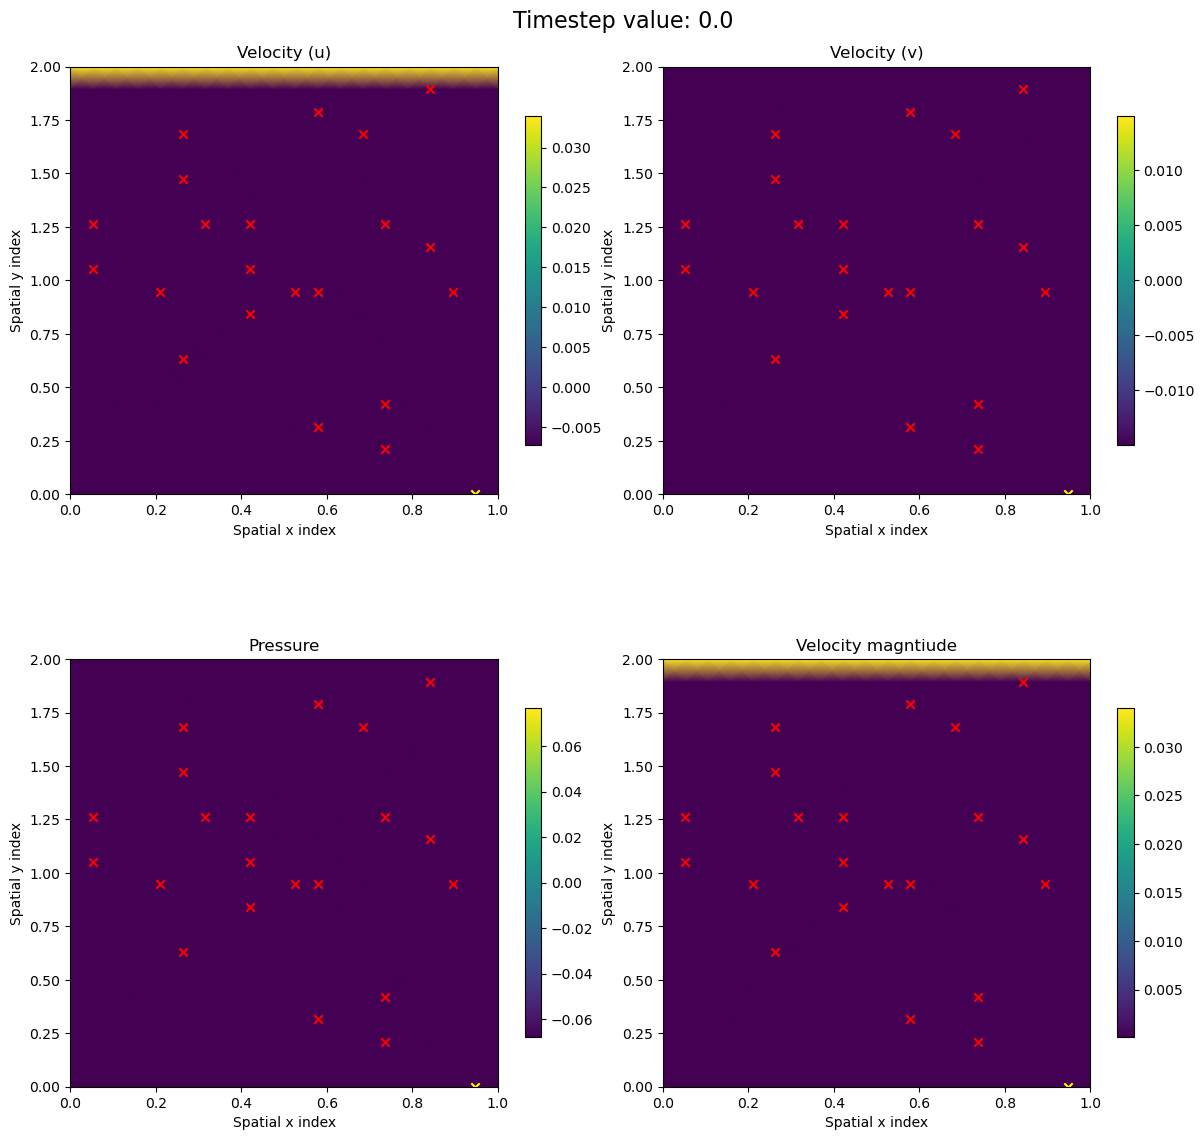

In [70]:
#QC training/testing selection with GIF using additional scatter ontop of quiver...will that work?
#Takes about 1.5 minutes to compute

#Decimate the timesteps for GIF output to avoid huge files and long creation time
animation_num_frames = 50
animation_write_interval = int(math.floor(ofoam_num_outputs / animation_num_frames))
print(f"Animation write interval: {animation_write_interval}")
print(f"OpenFOAM outputs: {ofoam_num_outputs}")
print(f"OpenFOAM start-end(dt): {start_time}-{end_time}({dt})")
print(f"# of animation frames: {animation_num_frames}")
print(f"OpenFOAM timesteps in animation: {range(0,int(ofoam_num_outputs),animation_write_interval)}")

fig, ax = plt.subplots(2,2, figsize=(12, 12))
fig.tight_layout()

#Compute magnitude of velocity
u_mag_full = np.sqrt(u_full.astype(np.double)**2 + v_full.astype(np.double)**2).astype(float)

#Use first timestep after initial condition to set the colour bar
fig.colorbar(ax[0][0].pcolormesh(grid2d_x,grid2d_y, u_full[1,:,:], shading='gouraud'), shrink=0.6, orientation='vertical')
fig.colorbar(ax[0][1].pcolormesh(grid2d_x,grid2d_y, v_full[1,:,:], shading='gouraud'), shrink=0.6, orientation='vertical')
fig.colorbar(ax[1][0].pcolormesh(grid2d_x,grid2d_y, p_full[1,:,:], shading='gouraud'), shrink=0.6, orientation='vertical')
fig.colorbar(ax[1][1].pcolormesh(grid2d_x,grid2d_y, u_mag_full[1,:,:], shading='gouraud'), shrink=0.6, orientation='vertical')

def animate_subplot(i):
    #Indexing values for plotting and GIF creation
    timestep_index = animation_write_interval * i
    timestep_time = timestep_index * dt

    fig.suptitle(f"Timestep value: {timestep_time}", fontsize=16)

    ax[0][0].pcolormesh(grid2d_x,grid2d_y, u_full[timestep_index,:,:], shading='gouraud')

    if timestep_index != 0:
        ax[0][0].quiver(grid2d_x,grid2d_y, u_full[timestep_index,:,:],v_full[timestep_index,:,:])

    ax[0][0].scatter(
        interior_training_locs[interior_training_locs[:,0] == timestep_time][:,2],
        interior_training_locs[interior_training_locs[:,0] == timestep_time][:,1], 
        c="Red",
        alpha=1,
        marker="x")
    ax[0][0].scatter(
        rightwall_training_locs[rightwall_training_locs[:,0] == timestep_time][:,2],
        rightwall_training_locs[rightwall_training_locs[:,0] == timestep_time][:,1], 
        c="Purple",
        alpha=1,
        marker="x")
    ax[0][0].scatter(
        leftwall_training_locs[leftwall_training_locs[:,0] == timestep_time][:,2],
        leftwall_training_locs[leftwall_training_locs[:,0] == timestep_time][:,1], 
        c="Purple",
        alpha=1,
        marker="x")
    ax[0][0].scatter(
        basewall_training_locs[basewall_training_locs[:,0] == timestep_time][:,2],
        basewall_training_locs[basewall_training_locs[:,0] == timestep_time][:,1], 
        c="Yellow",
        alpha=1,
        marker="x")

    ax[0][0].set_title("Velocity (u)")
    ax[0][0].set_ylabel("Spatial y index")
    ax[0][0].set_xlabel("Spatial x index")
    ax[0][0].set_box_aspect(1)

    ax[0][1].pcolormesh(grid2d_x,grid2d_y, v_full[timestep_index,:,:], shading='gouraud')
    if timestep_index != 0:
        ax[0][1].quiver(grid2d_x,grid2d_y, u_full[timestep_index,:,:],v_full[timestep_index,:,:])

    ax[0][1].scatter(
        interior_training_locs[interior_training_locs[:,0] == timestep_time][:,2],
        interior_training_locs[interior_training_locs[:,0] == timestep_time][:,1], 
        c="Red",
        alpha=1,
        marker="x")
    ax[0][1].scatter(
        rightwall_training_locs[rightwall_training_locs[:,0] == timestep_time][:,2],
        rightwall_training_locs[rightwall_training_locs[:,0] == timestep_time][:,1], 
        c="Purple",
        alpha=1,
        marker="x")
    ax[0][1].scatter(
        leftwall_training_locs[leftwall_training_locs[:,0] == timestep_time][:,2],
        leftwall_training_locs[leftwall_training_locs[:,0] == timestep_time][:,1], 
        c="Purple",
        alpha=1,
        marker="x")
    ax[0][1].scatter(
        basewall_training_locs[basewall_training_locs[:,0] == timestep_time][:,2],
        basewall_training_locs[basewall_training_locs[:,0] == timestep_time][:,1], 
        c="Yellow",
        alpha=1,
        marker="x")

    ax[0][1].set_title("Velocity (v)")
    ax[0][1].set_ylabel("Spatial y index")
    ax[0][1].set_xlabel("Spatial x index")
    ax[0][1].set_box_aspect(1)

    ax[1][0].pcolormesh(grid2d_x,grid2d_y, p_full[timestep_index,:,:], shading='gouraud')
    if timestep_index != 0:
        ax[1][0].quiver(grid2d_x,grid2d_y, u_full[timestep_index,:,:],v_full[timestep_index,:,:])

    ax[1][0].scatter(
        interior_training_locs[interior_training_locs[:,0] == timestep_time][:,2],
        interior_training_locs[interior_training_locs[:,0] == timestep_time][:,1], 
        c="Red",
        alpha=1,
        marker="x")
    ax[1][0].scatter(
        rightwall_training_locs[rightwall_training_locs[:,0] == timestep_time][:,2],
        rightwall_training_locs[rightwall_training_locs[:,0] == timestep_time][:,1], 
        c="Purple",
        alpha=1,
        marker="x")
    ax[1][0].scatter(
        leftwall_training_locs[leftwall_training_locs[:,0] == timestep_time][:,2],
        leftwall_training_locs[leftwall_training_locs[:,0] == timestep_time][:,1], 
        c="Purple",
        alpha=1,
        marker="x")
    ax[1][0].scatter(
        basewall_training_locs[basewall_training_locs[:,0] == timestep_time][:,2],
        basewall_training_locs[basewall_training_locs[:,0] == timestep_time][:,1], 
        c="Yellow",
        alpha=1,
        marker="x")

    ax[1][0].set_title("Pressure")
    ax[1][0].set_ylabel("Spatial y index")
    ax[1][0].set_xlabel("Spatial x index")
    ax[1][0].set_box_aspect(1)

    ax[1][1].pcolormesh(grid2d_x,grid2d_y, u_mag_full[timestep_index,:,:], shading='gouraud')
    if timestep_index != 0:
        ax[1][1].quiver(grid2d_x,grid2d_y, u_full[timestep_index,:,:],v_full[timestep_index,:,:])

    ax[1][1].scatter(
        interior_training_locs[interior_training_locs[:,0] == timestep_time][:,2],
        interior_training_locs[interior_training_locs[:,0] == timestep_time][:,1], 
        c="Red",
        alpha=1,
        marker="x")
    ax[1][1].scatter(
        rightwall_training_locs[rightwall_training_locs[:,0] == timestep_time][:,2],
        rightwall_training_locs[rightwall_training_locs[:,0] == timestep_time][:,1], 
        c="Purple",
        alpha=1,
        marker="x")
    ax[1][1].scatter(
        leftwall_training_locs[leftwall_training_locs[:,0] == timestep_time][:,2],
        leftwall_training_locs[leftwall_training_locs[:,0] == timestep_time][:,1], 
        c="Purple",
        alpha=1,
        marker="x")
    ax[1][1].scatter(
        basewall_training_locs[basewall_training_locs[:,0] == timestep_time][:,2],
        basewall_training_locs[basewall_training_locs[:,0] == timestep_time][:,1], 
        c="Yellow",
        alpha=1,
        marker="x")

    ax[1][1].set_title("Velocity magntiude")
    ax[1][1].set_ylabel("Spatial y index")
    ax[1][1].set_xlabel("Spatial x index")
    ax[1][1].set_box_aspect(1)

ani = animation.FuncAnimation(fig, animate_subplot, int(animation_num_frames), interval=1)
writervideo = animation.FFMpegWriter(fps=20)
ani.save(f'full_openfoam_outputframes{animation_num_frames}.mp4',writer=writervideo)

In [61]:
# Define MLP model architecture class
class NeuralNetwork(torch.nn.Module):
    def __init__(self):
        """_summary_
        """
        super().__init__()
        self.linear_stack = torch.nn.Sequential(
            torch.nn.Linear(3, 64),
            torch.nn.ReLU(),
            torch.nn.Linear(64, 64),
            torch.nn.ReLU(),
            torch.nn.Linear(64, 64),
            torch.nn.ReLU(),
            torch.nn.Linear(64, 64),
            torch.nn.ReLU(),
            torch.nn.Linear(64, 3)
        )

    def forward(self, x, y, t):
        """_summary_

        Args:
            x (_type_): _description_
            t (_type_): _description_

        Returns:
            _type_: _description_
        """
        inputs = torch.cat([x,y,t], axis=1).to(device)
        return self.linear_stack(inputs)

In [62]:
#Training loop

In [63]:
#Testing loop

In [64]:
#Loss function

In [65]:
#Main function

In [66]:
#QC plot and GIF using NN to predict fluid flow